# Predicting survival on the Titanic using sklearn's Decision Trees and Support Vector Machine

## Contributors: Philip Hartout, Vincent Roest & Bas Straathof


### Kaggle competition description

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

The challenge is to complete the analysis of what sorts of people were likely to survive, using machine learning tools to predict which passengers survived the tragedy.

# Note:
## The output underneath corresponds to the results evaluated in the report. The results are not reproducible, and running this notebook again in its entirity will take about 2 hours.

#### Required packages


In [23]:
# For data analysis and creating a convenient data frame
import pandas as pd

# For data pre-processing
from scipy.stats import mode

# For mathematics
import math
import numpy as np
from __future__ import division
%matplotlib inline

# For classification
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

# parameter estimation
from sklearn.grid_search import GridSearchCV

# For Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier

# For decision tree visualisation
from sklearn import tree

# For Random forest classifier
from sklearn.ensemble import RandomForestClassifier

# For SVM classifier
from sklearn.svm import SVC

# For learning curves
import matplotlib.pyplot as plt
from sklearn.learning_curve import learning_curve

# Confusion matrix requirements
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

# ROC curve
from sklearn.metrics import roc_curve

# Pipline
from sklearn.pipeline import Pipeline

## Pre-processing the data


#### Reading the data

In [24]:
df = pd.read_csv('train.csv', index_col='PassengerId')

#### Data visualisation



In [25]:
# Initially there are 11 features in the training set: Survived; Pclass; Name; Sex; Age; SibSp: # of siblings on board;
# Parch: # of parents/children on board; Ticket (name); Fare (cost); Cabin; Embarked (in)

# Data visualisation
df.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


#### Number of missing values per feature

In [26]:
feature_list = ["Survived", "Pclass", "Name", "Sex", "Age", "SibSp", "Parch", "Ticket", "Fare", "Cabin", "Embarked"]

for i in range(len(feature_list)):
    k = 0
    num_list = [0,0,0,0,0,0,0,0,0,0,0]
    for j in range(len(df)):
        if type((df[feature_list[i]][j+1])) == np.float64 or type((df[feature_list[i]][j+1])) == float:
            if math.isnan(df[feature_list[i]][j+1]):
                k += 1
    num_list[i] = k
    print "Number of missing values for '%s' = %i\n" % (feature_list[i], num_list[i])

Number of missing values for 'Survived' = 0

Number of missing values for 'Pclass' = 0

Number of missing values for 'Name' = 0

Number of missing values for 'Sex' = 0

Number of missing values for 'Age' = 177

Number of missing values for 'SibSp' = 0

Number of missing values for 'Parch' = 0

Number of missing values for 'Ticket' = 0

Number of missing values for 'Fare' = 0

Number of missing values for 'Cabin' = 687

Number of missing values for 'Embarked' = 2



### Survivors vs victims ratio

The Titanic hosted 2224 people when it hit the iceberg, and only 710 people were saved. Hence, the ratio of people
that survived the disaster is approximately 31.9%. The data set at hand only contains 892 passengers, and in the cell below we compute the survival ratio of this data set.

In [27]:
passengers = len(df['Survived'])
survived = len([k for i in range(len(df['Survived'])) if df['Survived'][i+1] == 1])

print "The survival ratio of this data set is %s percent." % round(survived / passengers * 100, 2)


The survival ratio of this data set is 38.38 percent.


##### Dropping "Name", "Ticket", and "Cabin"

In [28]:
# For the classification of survivors versus victims, the name of a passenger, as well as the name of the ticket
# do not seem relevant for classification, thus we can drop them. Also, as can be seen in the output above,
# there is hardly any data about cabins, so we drop that feature as well.
df = df.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [29]:
# Now the data looks like:
df.head(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S


##### Completing "Age" column

In [30]:
# In the data set, not all age fields are filled, but our classifiers need existant (numerical) input data.
# Therefore, let's assign the mean age to those fields, which will not impact the classifiers.
age_mean = df['Age'].mean()
df['Age'] = df['Age'].fillna(age_mean)
print age_mean

29.6991176471


##### Pre-processing the embarkment column

In [31]:
# Later, we will prove why it is important to know where passengers embarked on the RMS Titanic.
# Using mode from SciPy, the locations of embarkment can be split into three columns.
# Passengers embarked from S = Southampton, C = Cherbrough and Q = Queenstown.
# Now, if a passenger embarked at Queenstown, there is a one in the column for Q and a 0 in the columns of S and C.
mode_embarked = mode(df['Embarked'])[0][0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)

# We concatenate the three columns to our data frame.
df = pd.concat([df, pd.get_dummies(df['Embarked'], prefix='Embarked')], axis=1)
# And we can drop the initial column for Embarked
df = df.drop(['Embarked'], axis=1)
# Now, the data corresponding to the first three passengers in the data set looks like:
df.head(3)


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,0.0,0.0,1.0
2,1,1,female,38.0,1,0,71.2833,1.0,0.0,0.0
3,1,3,female,26.0,0,0,7.9250,0.0,0.0,1.0


##### Pre-processing the gender column

In [32]:
# Our classifiers need numerical data, hence, we map gender to an integer in the following way:
# female --> 0, male --> 1
df['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

# We should now drop the old "Sex" feature
df = df.drop(['Sex'], axis=1)

# Our data frame now looks like this:
df.head(3)


,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Gender
PassengerId,,,,,,,,,,
1,0,3,22.0,1,0,7.2500,0.0,0.0,1.0,1
2,1,1,38.0,1,0,71.2833,1.0,0.0,0.0,0
3,1,3,26.0,0,0,7.9250,0.0,0.0,1.0,0


##### Training set

In [33]:
# For the training set, we want to delete the passenger id indexation.
# This can be done by transforming columns to lists, removing the first list, and subsequently transforming
# everything to a column dataframe again.

survival_labels = df.values[:,0]
columns = df.columns.tolist()
columns = columns[1:]
df = df[columns]
data_set = df.values

##### Working features after preprocessing

In [34]:
features = df.columns.tolist()
features

['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Gender']

## Decision Tree classifier

In [35]:
# Manually tweaking parameters for GridSearchCV
parameter_grid = {
    'max_features': [None, 'sqrt', 'log2'], # maximum allowed number of features
    'max_depth': [None, 9, 8, 7, 6, 5], # maximum depth of the tree --> pruning
    'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8], # minimum number of samples to split on 
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], # the minimum number of samples required to be at a leaf node
    'presort': [True, False], # Presorting on features
}

# Decision Tree classifier with above parameters and a 7-fold crossvalidation set
clf_dt = GridSearchCV(DecisionTreeClassifier(), parameter_grid, cv = 7, verbose = 0)

# Splitting the data set into a training set (80%) and a test set (20%)
train_x_dt, test_x_dt, train_y_dt, test_y_dt = train_test_split(data_set, 
                                                    survival_labels, 
                                                    test_size = 0.2,
                                                    random_state = None) # seed used by the random number generator

# Fit trains the Decision Tree on the training set
clf_dt = clf_dt.fit(train_x_dt, train_y_dt)

# The best Decision Tree estimator
best_dt_estimator = clf_dt.best_estimator_

# Printing the score on the training set
print "- The accuracy on the training set is %s percent.\n" % round(clf_dt.score(train_x_dt, train_y_dt) * 100, 2)

# The mean and standard deviation of the mean over the folds, and the best parameters.
print "- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:"
print sorted(clf_dt.grid_scores_, key=lambda x: x.mean_validation_score)[-1:]

# Printing the best Decision Tree estimator.
print "\n- The best Decision Tree estimator for the Titanic survival classification problem is:"
print best_dt_estimator

print "\n This is the percental importance of the features:"
print best_dt_estimator.feature_importances_

# Predict classifies the unseen examples (i.e. examples from the test set) on the best found classifier.
predict_y_dt = clf_dt.predict(test_x_dt)

- The accuracy on the training set is 87.64 percent.

- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:
[mean: 0.83427, std: 0.02542, params: {'max_features': None, 'min_samples_split': 4, 'presort': True, 'max_depth': 7, 'min_samples_leaf': 1}]

- The best Decision Tree estimator for the Titanic survival classification problem is:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=4, min_weight_fraction_leaf=0.0,
            presort=True, random_state=None, splitter='best')

 This is the percental importance of the features:
[ 0.19047683  0.11477702  0.05789761  0.          0.18729827  0.00638123
  0.          0.00932169  0.43384735]


###  ERROR ANALYSIS OF THE DECISION TREE CLASSIFIER

In [36]:
def error_analysis(test_y, predict_y):
    '''This function takes as input the labels of the test set and the predicted values
    of the classifier on the test set. The output is the accuracy of the estimator on
    the test set, the confusion matrix, and the precision recall matrix.'''
    
    print ("- The accuracy on the test set for the best found classifier is %s percent\n\n" %
           round(((accuracy_score(test_y, predict_y)) * 100), 2))

    confusion_matrix = metrics.confusion_matrix(test_y, predict_y)
    print "CONFUSION MATRIX\n"
    print "               actual        "
    print "       |     0    |    1     "
    print "     --|----------|---------"
    print ("     0 | #TP : %d"%  confusion_matrix[1,1]) + " | #FP: %d " % confusion_matrix[0,1]
    print "pred --|----------|---------"
    print "     1 | #FN : %d" % confusion_matrix[1,0] + " | #TN: %d \n\n\n" % confusion_matrix[0,0]

    print "PRECISION RECALL MATRIX\n"
    print(classification_report(test_y, 
                                predict_y, 
                                target_names = ['Lost', 'Survived']))

In [37]:
print "This is the error analysis of the best found Decision tree classifier:\n"
error_analysis(test_y_dt, predict_y_dt)

This is the error analysis of the best found Decision tree classifier:

- The accuracy on the test set for the best found classifier is 85.47 percent


CONFUSION MATRIX

               actual        
       |     0    |    1     
     --|----------|---------
     0 | #TP : 50 | #FP: 6 
pred --|----------|---------
     1 | #FN : 20 | #TN: 103 



PRECISION RECALL MATRIX

             precision    recall  f1-score   support

       Lost       0.84      0.94      0.89       109
   Survived       0.89      0.71      0.79        70

avg / total       0.86      0.85      0.85       179



### DECISION TREE VISUALISATION

A decision tree can be visualized using the Graphviz (http://www.graphviz.org/) software.
We use the best Decision Tree estimator for visualization. Running the code in the cell
below creates a .dot file, which can be read using the Graphviz software.

In [38]:
# We refit the training data using the best Decision Tree estimator and export the tree.dot file.
decision_tree = best_dt_estimator.fit(train_x_dt, train_y_dt)
tree.export_graphviz(decision_tree, out_file='tree.dot', feature_names=features)

##  Random Forest Classifier (using 300 trees)
It should be noted that the accuracy increases as the number of trees increases, although the incremental gain becomes smaller and smaller as the number of trees grows which, in the end, is outweighed by the computational calculations. Subsequently, we have used three common values of tree number to compute random forests.  

In [39]:
# The parameters that GridSearchCV() tries out in order to find the best estimator
parameter_grid = {
    'n_estimators': [300], # maximum allowed number of trees
    'max_depth': [None, 9, 8, 7, 6, 5], # maximum depth of the tree --> pruning
    'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9], # minimum number of samples to split on 
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], # minimum number of samples required to be a leaf node
    #'oob_score': [True, False], # whether to use out-of-bag samples to estimate the generalization accuracy
    # It was found that running 10 Random forests, it is preferable to set the oob_score to false.

}

# Random Tree classifier with above parameters and a 7-fold crossvalidation set
clf_rf = GridSearchCV(RandomForestClassifier(), parameter_grid, cv = 7, verbose = 1)

# Splitting the data set into a training set (80%) and a test set (20%)
train_x_rf, test_x_rf, train_y_rf, test_y_rf = train_test_split(data_set, 
                                                    survival_labels, 
                                                    test_size = 0.20,
                                                    random_state = None) # seed used by the random number generator

# Fit trains the Decision Tree on the training set
clf_rf = clf_rf.fit(train_x_rf, train_y_rf)

# Best Random Forest estimator
best_rf_estimator = clf_rf.best_estimator_

# Printing the score on the training set
print "- The accuracy on the training set is %s percent" % round(clf_rf.score(train_x_rf, train_y_rf) * 100, 2)

# The mean and standard deviation of the mean over the folds, and the best parameters.
print "- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:"
print sorted(clf_rf.grid_scores_, key=lambda x: x.mean_validation_score)[-1:]

# Printing the best Decision Tree estimator.
print "\n- The best Random Forrest estimator for the Titanic survival classification problem is:"
print clf_rf.best_estimator_

# Printing the percental importance of the features
print "\n This is the percental importance of the features:"
print best_rf_estimator.feature_importances_

# Predict classifies the unseen examples (i.e. examples from the test set) on the best found classifier.
predict_y_rf = clf_rf.predict(test_x_rf)

Fitting 7 folds for each of 378 candidates, totalling 2646 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   31.4s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  2.1min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  4.5min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  7.9min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed: 12.2min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed: 17.3min
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed: 23.8min
[Parallel(n_jobs=1)]: Done 2646 out of 2646 | elapsed: 25.7min finished


- The accuracy on the training set is 90.31 percent
- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:
[mean: 0.82163, std: 0.03550, params: {'min_samples_split': 7, 'n_estimators': 300, 'max_depth': 9, 'min_samples_leaf': 2}]

- The best Random Forrest estimator for the Titanic survival classification problem is:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=7,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 This is the percental importance of the features:
[ 0.12145232  0.15875543  0.05499178  0.03484205  0.22277588  0.01866741
  0.00727207  0.01548303  0.36576003]


###  ERROR ANALYSIS OF THE RANDOM FORESTS

In [40]:
print "This is the error analysis of the best found Random Forrest classifier:\n"
error_analysis(test_y_rf, predict_y_rf)

This is the error analysis of the best found Random Forrest classifier:

- The accuracy on the test set for the best found classifier is 83.24 percent


CONFUSION MATRIX

               actual        
       |     0    |    1     
     --|----------|---------
     0 | #TP : 58 | #FP: 13 
pred --|----------|---------
     1 | #FN : 17 | #TN: 91 



PRECISION RECALL MATRIX

             precision    recall  f1-score   support

       Lost       0.84      0.88      0.86       104
   Survived       0.82      0.77      0.79        75

avg / total       0.83      0.83      0.83       179



## Random Forrest with place of embarkation dropped

Intuitively one would say that the location of embarkment does not have a big impact on the chance of survival of a passenger. Let's see if this hypothesis is true or not.

In [41]:
# Remove the columns for 'Embarked_C', 'Embarked_Q' 'Embarked_S'.
columns = columns[0:5] + columns[8:9]
df_emb = df[columns]
df_emb.head(3)
print df_emb.columns.tolist()
print df.columns.tolist()

# Modified training set
train_set_without_embarkment = df_emb.values

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Gender']
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Gender']


In [42]:
# The parameters that GridSearchCV() tries out in order to find the best estimator
parameter_grid = {
    'n_estimators': [300], # maximum allowed number of trees
    'max_depth': [None, 9, 8, 7, 6, 5], # maximum depth of the tree --> pruning
    'min_samples_split': [1, 2, 3,4 ,5 ,6 ,7 ,8 ,9], # minimum number of samples to split on 
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7], # minimum number of samples required to be a leaf node
}

# Random Tree classifier with above parameters and a 7-fold crossvalidation set, without the embarkment feature
clf_rf_emb = GridSearchCV(RandomForestClassifier(), parameter_grid, cv = 7, verbose = 1)

# Splitting the data set into a training set (80%) and a test set (20%)
train_x_rf_emb, test_x_rf_emb, train_y_rf_emb, test_y_rf_emb = train_test_split(train_set_without_embarkment, 
                                                    survival_labels, 
                                                    test_size = 0.20,
                                                    random_state = None) # seed used by the random number generator


# Fit trains the Decision Tree on the training set
clf_rf_emb = clf_rf_emb.fit(train_x_rf_emb, train_y_rf_emb)

# Best Random Forest without place of embarkation estimator
best_rf_emb_estimator = clf_rf_emb.best_estimator_

# Printing the score on the training set
print "- The accuracy on the training set is %s percent" % round(clf_rf_emb.score(train_x_rf_emb, train_y_rf_emb) * 100, 2)

# The mean and standard deviation of the mean over the folds, and the best parameters.
print "- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:"
print sorted(clf_rf_emb.grid_scores_, key=lambda x: x.mean_validation_score)[-1:]

# Printing the best Random Forrest estimator.
print "\n- The best Random Forrest estimator for the Titanic survival classification problem is:"
print clf_rf_emb.best_estimator_

# Printing the percental importance of the features
print "\n This is the percental importance of the features:"
print best_rf_emb_estimator.feature_importances_

# Predict classifies the unseen examples (i.e. examples from the test set) on the best found classifier.
predict_y_rf_emb = clf_rf_emb.predict(test_x_rf_emb)

Fitting 7 folds for each of 378 candidates, totalling 2646 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   30.0s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  2.0min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  4.4min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  7.7min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed: 11.8min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed: 16.8min
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed: 22.7min
[Parallel(n_jobs=1)]: Done 2646 out of 2646 | elapsed: 24.5min finished


- The accuracy on the training set is 88.62 percent
- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:
[mean: 0.84129, std: 0.04112, params: {'min_samples_split': 2, 'n_estimators': 300, 'max_depth': 7, 'min_samples_leaf': 4}]

- The best Random Forrest estimator for the Titanic survival classification problem is:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=2, min_samples_split=6,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

 This is the percental importance of the features:
[ 0.14080404  0.1481851   0.05008582  0.0396013   0.2232137   0.39811005]


###  ERROR ANALYSIS OF THE RANDOM FORESTS WITH PLACE OF EMBARKATION DROPPED

In [43]:
print "This is the error analysis of the best found Random Forrest classifier with the place of embarkation dropped:\n"
error_analysis(test_y_rf_emb, predict_y_rf_emb)

This is the error analysis of the best found Random Forrest classifier with the place of embarkation dropped:

- The accuracy on the test set for the best found classifier is 82.68 percent


CONFUSION MATRIX

               actual        
       |     0    |    1     
     --|----------|---------
     0 | #TP : 50 | #FP: 8 
pred --|----------|---------
     1 | #FN : 23 | #TN: 98 



PRECISION RECALL MATRIX

             precision    recall  f1-score   support

       Lost       0.81      0.92      0.86       106
   Survived       0.86      0.68      0.76        73

avg / total       0.83      0.83      0.82       179



## Support Vector Machine classifier


In [44]:
# SVC classifier
cls = SVC()

# Pipeline can be used to use various kernels. 
classifiers = Pipeline([('std', StandardScaler()), # StandardScalar() standardizes features by removing the mean and scaling to unit variance 
                       ('svc', cls)])

param_grid = [
  {'svc__C': [1, 5, 10, 100], # penalty parameter C of the error term.
   'svc__gamma': [0.01, 0.05, 0.1, 'auto', 0.2], # kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. If gamma is ‘auto’ then 1/n_features will be used instead.
   'svc__kernel': ['rbf', 'linear', 'sigmoid', 'poly'], # type of kernel
   'svc__degree': [2, 3], # degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
   'svc__decision_function_shape': ['ovo', 'ovr'], # Whether to return a one-vs-rest (‘ovr’) decision function, or the original one-vs-one (‘ovo’) decision function . 
}]

# Using GridSearchCV to find the best Support Vector Machine classifier
clf_svm = GridSearchCV(estimator = classifiers, 
                  param_grid = param_grid, 
                  scoring = 'accuracy', 
                  cv = 7, 
                  verbose = 1)

# Splitting the data set into a training set (80%) and a test set (20%)
train_x_svm, test_x_svm, train_y_svm, test_y_svm = train_test_split(data_set, survival_labels,
                                                                    test_size=0.20, random_state=42)

# Fit trains the Support Vector Machine on the training set
clf_svm = clf_svm.fit(train_x_svm, train_y_svm)

# Best SVM estimator
best_svm_estimator = clf_svm.best_estimator_

# Printing the score on the training set
print "- The accuracy on the training set is %s percent" % round(clf_svm.score(train_x_svm, train_y_svm) * 100, 2)


# The mean and standard deviation of the mean over the folds, and the best parameters.
print "- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:"
print sorted(clf_svm.grid_scores_, key=lambda x: x.mean_validation_score)[-1:]

# Printing the best Support Vector Machine estimator.
print "\n- The best Support Vector Machine estimator for the Titanic survival classification problem is:"
print clf_svm.best_estimator_

# Predict classifies the unseen examples (i.e. examples from the test set) on the best found classifier.
predict_y_svm = clf_svm.predict(test_x_svm)

Fitting 7 folds for each of 320 candidates, totalling 2240 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    6.4s
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:   12.5s
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:   21.6s
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed:   45.8s


- The accuracy on the training set is 85.39 percent
- These are the mean and standard deviation over the folds, and a dictionary of the best parameters:
[mean: 0.83287, std: 0.05288, params: {'svc__gamma': 'auto', 'svc__degree': 3, 'svc__kernel': 'rbf', 'svc__C': 5, 'svc__decision_function_shape': 'ovr'}]

- The best Support Vector Machine estimator for the Titanic survival classification problem is:
Pipeline(steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=2, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])


[Parallel(n_jobs=1)]: Done 2240 out of 2240 | elapsed:  1.8min finished


###  ERROR ANALYSIS OF THE BEST SUPPORT VECTOR MACHINE ESTIMATOR

In [45]:
print "This is the error analysis of the best found Support Vector Machine estimator with the place of embarkation dropped:\n"
error_analysis(test_y_svm, predict_y_svm)

This is the error analysis of the best found Support Vector Machine estimator with the place of embarkation dropped:

- The accuracy on the test set for the best found classifier is 82.12 percent


CONFUSION MATRIX

               actual        
       |     0    |    1     
     --|----------|---------
     0 | #TP : 51 | #FP: 9 
pred --|----------|---------
     1 | #FN : 23 | #TN: 96 



PRECISION RECALL MATRIX

             precision    recall  f1-score   support

       Lost       0.81      0.91      0.86       105
   Survived       0.85      0.69      0.76        74

avg / total       0.82      0.82      0.82       179



## Learning curve function

In [46]:
def plot_learning_curve(estimator, title, X, y, cv=7,
                         train_sizes=np.linspace(.1, 1.0, 15)): 
    """This function plots a learning curve for the training scores and
    cross-validation scores of an estimator, showing 15 intermediate points.
    Note that if the best estimator of a classifier is given as input to this
    function, that the learning curves are not unique because each time this
    function is called the 7-fold cross-validation regimes are chosen in a
    different way."""
    plt.figure() # Initialize a figure
    plt.title(title) # Plot the title
    plt.xlabel("Training examples") # Plot the x-label
    plt.ylabel("Score") # Plot the y-label
    
    # Gauging training and testing scores
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes)
    
    # The mean of the training scores
    train_scores_mean = np.mean(train_scores, axis=1)
    # The standard deviation of the training scores
    train_scores_std = np.std(train_scores, axis=1)

    # The mean of the test scores
    test_scores_mean = np.mean(test_scores, axis=1)
    # The standard deviation of the test scores
    test_scores_std = np.std(test_scores, axis=1)
    
    # Plot a grid on the graph
    plt.grid()

    # Training curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    
    # Cross-validation curve
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

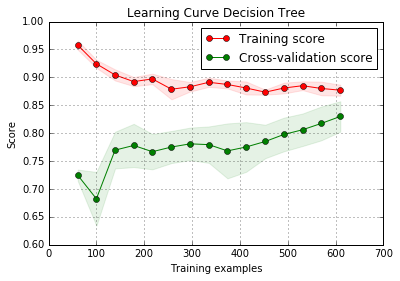

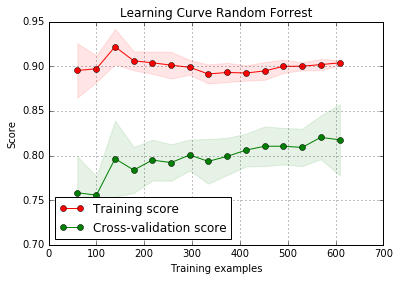

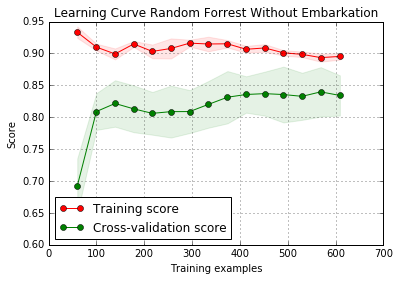

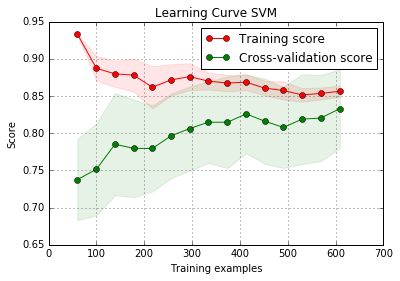

In [47]:
# Learning curve for the best Decision Tree estimator.
plot_learning_curve(best_dt_estimator, 'Learning Curve Decision Tree', train_x_dt, train_y_dt)
plt.show()

# Learning curve for the best Random Forrest estimator.
plot_learning_curve(best_rf_estimator, 'Learning Curve Random Forrest', train_x_rf, train_y_rf)
plt.show()

# Learning curve for the best Random Forrest estimator without location of embarkation
plot_learning_curve(best_rf_emb_estimator, 'Learning Curve Random Forrest Without Embarkation', train_x_rf_emb, train_y_rf_emb)
plt.show()

# Learning curve for the best Support Vector Machine Tree estimator.
plot_learning_curve(best_svm_estimator, "Learning Curve SVM", train_x_svm, train_y_svm)
plt.show()

### ROC CURVES

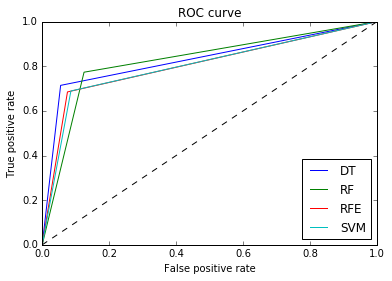

In [48]:
# For the best Decision Tree estimator
fpr_dt, tpr_dt, _ = roc_curve(test_y_dt, predict_y_dt)

# For the best Random Forrest estimator
fpr_rf, tpr_rf, _ = roc_curve(test_y_rf, predict_y_rf)

# For the best Random Forrest estimator without place of embarkation
fpr_rf_emb, tpr_rf_emb, _ = roc_curve(test_y_rf_emb, predict_y_rf_emb)

# For the best Support Vector Machine estimator
fpr_svm, tpr_svm, _ = roc_curve(test_y_svm, predict_y_svm)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_dt, tpr_dt, label='DT')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_emb, tpr_rf_emb, label="RFE")
plt.plot(fpr_svm, tpr_svm, label='SVM')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()
